# **Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

## **Edición 2024**


----

# Trabajo práctico entregable - parte 2


Trabajaremos con la base de datos de `melb_data.csv` presentada a continuación.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

sns.set_context('talk')

In [2]:
url = 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv'
melb_df = pd.read_csv(url)

## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas.
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


### 1.1 Selección de datos

Se crea un nuevo DataFrame a partir de 'melb_df', eliminando las columnas `BuildingArea` y `YearBuilt`. Además se eliminan las columnas:

- Address: la cantidad de valores unicos son 13378. Esto no es un problema en principio, pero puede llegar a relentizar Colab y además ya se cuenta con los valores de Longitud Latitud para saber la posición
- SellerG: es el nombre del agente que vendio la propiedad. Para este trabajo no se consideran irrelevantes

In [3]:
df = melb_df.drop(columns=['SellerG','Address', 'BuildingArea', 'YearBuilt'], inplace=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Rooms          13580 non-null  int64  
 2   Type           13580 non-null  object 
 3   Price          13580 non-null  float64
 4   Method         13580 non-null  object 
 5   Date           13580 non-null  object 
 6   Distance       13580 non-null  float64
 7   Postcode       13580 non-null  float64
 8   Bedroom2       13580 non-null  float64
 9   Bathroom       13580 non-null  float64
 10  Car            13518 non-null  float64
 11  Landsize       13580 non-null  float64
 12  CouncilArea    12211 non-null  object 
 13  Lattitude      13580 non-null  float64
 14  Longtitude     13580 non-null  float64
 15  Regionname     13580 non-null  object 
 16  Propertycount  13580 non-null  float64
dtypes: float64(10), int64(1), object(6)
memory usage: 

La variable 'Date' tambien es tipo objeto, se puede convertir a fecha

In [5]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [6]:
df.Date.head(1)

0   2016-12-03
Name: Date, dtype: datetime64[ns]

Se observa que 'Date' tiene año, mes y día. Para saber la diferencia máxima se tiene

In [7]:
print('Difencia de', (df.Date.max() - df.Date.min()).days, 'días')

Difencia de 604 días


Esta variable representa cuando fueron vendidas las propiedas. Para este análisis no representaria informacion necesaria ya que el rango de ventas es menor a dos años. También se elimina esta columna

In [8]:
df = df.drop(columns=['Date'])

### 1.2 One-hot encoding

Se extraen los nombres de las columnas que contienen variables numéricas y categóricas

In [9]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

In [10]:
print('Variables categóricas: ', categorical_columns.to_list())

Variables categóricas:  ['Suburb', 'Type', 'Method', 'CouncilArea', 'Regionname']


Las variables Type y Method hacen referencia al tipo de vivienda y el método de venta. La cantidad de valores únicos para ambos son

In [11]:
df.Type.nunique(), df.Method.nunique()

(3, 5)

Se crean dos listas con los valores

In [12]:
type_list = df.Type.unique().tolist()

In [13]:
method_list = df.Method.unique().tolist()

In [14]:
print('Valores de Type:\t', type_list)
print('Valores de Method:\t', method_list)

Valores de Type:	 ['h', 'u', 't']
Valores de Method:	 ['S', 'SP', 'PI', 'VB', 'SA']


Al tener pocos valores unicos se puse implementar `OrdinalEncoder` para transformarlas en variables numéricas, asignando un número a cada categoria y manteniendo todo dentro de una misma columna

In [15]:
from sklearn.preprocessing import OrdinalEncoder

Se les va a dar el siguiente orden:

**Method:**

0. S - property sold
1. SP - property sold prior
2. PI - property passed in
3. VB - vendor bid
4. SA - sold after auction

**Type:**

0. h - house,cottage,villa, semi,terrace
1. u - unit, duplex
2. t - townhouse

Se instancia el codificador

In [16]:
encoder_type = OrdinalEncoder(categories=[['h', 'u', 't']])
encoder_method = OrdinalEncoder(categories=[['S', 'SP', 'PI', 'VB', 'SA']])

Se ajusta el codificador a cada tipo de variable

In [17]:
encoder_type.fit(df[['Type']])

OrdinalEncoder(categories=[['h', 'u', 't']])

In [18]:
encoder_method.fit(df[['Method']])

OrdinalEncoder(categories=[['S', 'SP', 'PI', 'VB', 'SA']])

Se transforman los datos

In [19]:
df['Type_encoded'] = encoder_type.transform(df[['Type']])
df['Method_encoded'] = encoder_method.transform(df[['Method']])

Se obtienen dos columnas adicionales con los valores codificados

In [20]:
df[['Type', 'Type_encoded', 'Method', 'Method_encoded']].sample(10)

,Type,Type_encoded,Method,Method_encoded
13286,h,0.0,S,0.0
1720,u,1.0,S,0.0
11590,h,0.0,SP,1.0
7982,h,0.0,VB,3.0
13369,h,0.0,S,0.0
1911,t,2.0,VB,3.0
5625,u,1.0,S,0.0
1773,h,0.0,PI,2.0
4521,h,0.0,S,0.0
12116,h,0.0,PI,2.0


Finalmente se borran las columnas con las variables categóricas

In [21]:
df = df.drop(columns=['Type', 'Method'])

Se vuelven a crear las variables con los nombres de las columnas

In [22]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

Se observa que variables tienen valores nulos

In [23]:
df[numeric_columns].isna().sum()

Rooms              0
Price              0
Distance           0
Postcode           0
Bedroom2           0
Bathroom           0
Car               62
Landsize           0
Lattitude          0
Longtitude         0
Propertycount      0
Type_encoded       0
Method_encoded     0
dtype: int64

In [24]:
df[categorical_columns].isna().sum()

Suburb            0
CouncilArea    1369
Regionname        0
dtype: int64

Se observa que para las variables Car y CouncilArea se tiene valores nulos. Para 'Car' los valores nulos se reemplazan con 0, ya que equivale a que la vivienda no cuenta con estacionamiento

In [25]:
df['Car'] = df['Car'].fillna(value=0)

CouncilArea tiene 1369 datos faltantes. Por trabajos anteriores se sabe que el dataset cuenta con una columna de código postal, con la cual podemos establecer una relacion con los datos faltantes

Se crea un nuevo DataFrame solo con los valores de CouncilArea nulos y una lista de los mismos pero de los Postcode

In [26]:
df_council_isna = df[df.CouncilArea.isna()]
council_isna_list = df_council_isna.Postcode.unique().tolist()

In [27]:
print('Cantidad de filas:\t', df_council_isna.shape[0])
print('Largo de la lista:\t', len(council_isna_list))

Cantidad de filas:	 1369
Largo de la lista:	 170


Se crea otro DataFrame con las siguiente condiciones forma simulatenea (and):
- CouncilArea **no** nulos
- Postcode este dentro de la lista de los CouncilArea con datos nulos

De esta manera obtenemos la relacion que hay entre CouncilArea y Postcode de todos los datos que estan completos

In [28]:
df_council = df[df.CouncilArea.notna() & df.Postcode.isin(council_isna_list)]

A partir de este DataFrame se crea un diccionario de Postcode con su CouncilArea correspondiente mediante el método `.set_index()` se establece el indice y luego se crea el diccionario con `.to_dict()`

In [29]:
diccionario = df_council.set_index('Postcode')['CouncilArea'].to_dict()

In [30]:
print(diccionario)

{3067.0: 'Yarra', 3042.0: 'Brimbank', 3206.0: 'Port Phillip', 3078.0: 'Darebin', 3018.0: 'Hobsons Bay', 3025.0: 'Hobsons Bay', 3143.0: 'Stonnington', 3032.0: 'Moonee Valley', 3147.0: 'Monash', 3034.0: 'Moonee Valley', 3183.0: 'Port Phillip', 3103.0: 'Boroondara', 3104.0: 'Boroondara', 3204.0: 'Glen Eira', 3165.0: 'Glen Eira', 3128.0: 'Whitehorse', 3019.0: 'Maribyrnong', 3186.0: 'Bayside', 3187.0: 'Bayside', 3056.0: 'Moreland', 3055.0: 'Moreland', 3105.0: 'Manningham', 3125.0: 'Whitehorse', 3124.0: 'Boroondara', 3126.0: 'Boroondara', 3054.0: 'Yarra', 3163.0: 'Glen Eira', 3162.0: 'Glen Eira', 3148.0: 'Monash', 3068.0: 'Yarra', 3058.0: 'Moreland', 3066.0: 'Yarra', 3108.0: 'Manningham', 3084.0: 'Banyule', 3185.0: 'Port Phillip', 3184.0: 'Port Phillip', 3040.0: 'Moonee Valley', 3041.0: 'Moonee Valley', 3065.0: 'Yarra', 3031.0: 'Melbourne', 3011.0: 'Maribyrnong', 3146.0: 'Stonnington', 3046.0: 'Moreland', 3043.0: 'Hume', 3188.0: 'Bayside', 3122.0: 'Boroondara', 3081.0: 'Banyule', 3166.0: 'Mo

Se crea un bucle for donde se itera sobre las filas del DataFrame con CouncilArea faltantes. Luego se obtiene el Postcode de la fila actual y se busca en el diccionario. Si existe, se agrega al diccionario para reemplezar

In [31]:
diccionario_reemplazos = {}

for i, row in df_council_isna.iterrows():   # i: índice, row: fila
    postcode = row['Postcode']
    if postcode in diccionario:
        diccionario_reemplazos[i] = diccionario[postcode]

In [32]:
print('Cantidad de reemplazos: ',len(diccionario_reemplazos))

Cantidad de reemplazos:  1366


Se reemplazan los valores faltantes con el metodo `.fillna()` y el diccionario con los reemplazos

In [33]:
df.CouncilArea = df.CouncilArea.fillna(value=diccionario_reemplazos)

Pero todavia faltan 3 datos faltantes

In [34]:
df.CouncilArea.isna().sum()

3

Para saber cuales son los datos faltantes filtramos con CouncilArea nulos y Postcode único

In [35]:
df[df.CouncilArea.isna()].Postcode.unique()

array([3756., 3438., 3793.])

Según ChatGPT:


Los códigos postales 3756, 3438 y 3793 corresponden a las siguientes áreas de consejo (Council Areas) en Australia:

- **3756 (Wallan)**: Corresponde al **Mitchell Shire** en el estado de Victoria.
- **3438 (Romsey)**: Corresponde al **Macedon Ranges Shire** en el estado de Victoria.
- **3793 (Seville East)**: Corresponde al **Yarra Ranges Shire** en el estado de Victoria.

Cada una de estas áreas de consejo administra sus respectivas regiones dentro del estado de Victoria.

Se buscan los registros con estos Postcode

In [36]:
df[df.Postcode.isin([3756., 3438., 3793.])]

,Suburb,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Type_encoded,Method_encoded
12865,Wallan,3,366000.0,44.2,3756.0,3.0,1.0,1.0,502.0,NaN,-37.40853,144.97749,Northern Victoria,3988.0,0.0,0.0
13245,New Gisborne,5,1355000.0,48.1,3438.0,5.0,3.0,5.0,44500.0,NaN,-37.45392,144.58864,Northern Victoria,849.0,0.0,0.0
13494,Monbulk,4,720000.0,34.1,3793.0,4.0,2.0,2.0,1611.0,NaN,-37.87931,145.41288,Eastern Victoria,1424.0,0.0,1.0


Finalmente se reemplazan los valores faltantes

In [37]:
df.loc[12865, 'CouncilArea'] = 'Mitchel'
df.loc[13245, 'CouncilArea'] = 'Macedon Ranges'
df.loc[13494, 'CouncilArea'] = 'Yarra Ranges'

Ahora el DataFrame principal no tiene valores nulos

In [38]:
df.isna().sum()

Suburb            0
Rooms             0
Price             0
Distance          0
Postcode          0
Bedroom2          0
Bathroom          0
Car               0
Landsize          0
CouncilArea       0
Lattitude         0
Longtitude        0
Regionname        0
Propertycount     0
Type_encoded      0
Method_encoded    0
dtype: int64

#### OneHotEncoder

Primero se importa el módulo `OneHotEncoder`

In [39]:
from sklearn.preprocessing import OneHotEncoder

Se crean dos arreglos, uno con las variables numéricas y otro con las variables categóricas


In [40]:
numeric_data = df[numeric_columns].values
categorical_data = df[categorical_columns]

Se crea la instancia `OneHotEncoder`

In [41]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

Se entrena el codificador con el método `.fit()` para aplicar el encoding

In [42]:
encoder.fit(categorical_data)

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

Con el método `.transform()` se contruye los encoding a cada fila del conjunto de datos

In [43]:
encoded_categorical_data = encoder.transform(categorical_data)

Se concatena los datos numéricos con los nuevos datos codificados de las variables categóricas

In [44]:
encoded_data = np.hstack([numeric_data, encoded_categorical_data])

In [45]:
print('Filas:\t', encoded_data.shape[0])
print('Cols.:\t', encoded_data.shape[1])

Filas:	 13580
Cols.:	 369


Se crea una lista con los nombres de las nuevas columnas para formar un DataFrame

In [46]:
feature_columns = list(numeric_columns) + encoder.get_feature_names_out().tolist()

In [47]:
print(feature_columns)

['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Lattitude', 'Longtitude', 'Propertycount', 'Type_encoded', 'Method_encoded', 'Suburb_Abbotsford', 'Suburb_Aberfeldie', 'Suburb_Airport West', 'Suburb_Albanvale', 'Suburb_Albert Park', 'Suburb_Albion', 'Suburb_Alphington', 'Suburb_Altona', 'Suburb_Altona Meadows', 'Suburb_Altona North', 'Suburb_Ardeer', 'Suburb_Armadale', 'Suburb_Ascot Vale', 'Suburb_Ashburton', 'Suburb_Ashwood', 'Suburb_Aspendale', 'Suburb_Aspendale Gardens', 'Suburb_Attwood', 'Suburb_Avondale Heights', 'Suburb_Bacchus Marsh', 'Suburb_Balaclava', 'Suburb_Balwyn', 'Suburb_Balwyn North', 'Suburb_Bayswater', 'Suburb_Bayswater North', 'Suburb_Beaconsfield', 'Suburb_Beaconsfield Upper', 'Suburb_Beaumaris', 'Suburb_Bellfield', 'Suburb_Bentleigh', 'Suburb_Bentleigh East', 'Suburb_Berwick', 'Suburb_Black Rock', 'Suburb_Blackburn', 'Suburb_Blackburn North', 'Suburb_Blackburn South', 'Suburb_Bonbeach', 'Suburb_Boronia', 'Suburb_Box Hill', 'Sub

In [48]:
df_encoded = pd.DataFrame(encoded_data, columns=feature_columns)

In [49]:
df_encoded.sample(2)

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,...,CouncilArea_Yarra,CouncilArea_Yarra Ranges,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
7878,1.0,260000.0,10.4,3163.0,1.0,1.0,1.0,1162.0,-37.89110,145.04510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8745,1.0,380000.0,10.5,3186.0,1.0,1.0,1.0,1993.0,-37.88468,144.99722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### DictVectorizer

Primer se importa el modulo ```DictVectorizer```



In [50]:
from sklearn.feature_extraction import DictVectorizer

Se crea un diccionario con el nombre de columnas del DataFrame, las cuales seran las características (features) para realizar One-hoy coding

In [51]:
df_dict = df.to_dict(orient="records")

In [52]:
df_dict[:1]

[{'Suburb': 'Abbotsford',
  'Rooms': 2,
  'Price': 1480000.0,
  'Distance': 2.5,
  'Postcode': 3067.0,
  'Bedroom2': 2.0,
  'Bathroom': 1.0,
  'Car': 1.0,
  'Landsize': 202.0,
  'CouncilArea': 'Yarra',
  'Lattitude': -37.7996,
  'Longtitude': 144.9984,
  'Regionname': 'Northern Metropolitan',
  'Propertycount': 4019.0,
  'Type_encoded': 0.0,
  'Method_encoded': 0.0}]

Se crea una instancia de `DicVectorizer`

In [53]:
vector = DictVectorizer(sparse=False)

Con la instancia se conviete el diccionario en matrices de caracteristicas (features). El parámetro `.fit()` ajusta la instancia `DicVectorizer` para aprender el mapeo de las variables categóricas a un valor numérico y se transformna

In [54]:
vect_data = vector.fit_transform(df_dict)

In [55]:
vect_data

array([[1., 2., 1., ..., 0., 0., 0.],
       [1., 2., 0., ..., 0., 0., 0.],
       [2., 3., 0., ..., 0., 0., 0.],
       ...,
       [2., 3., 4., ..., 0., 0., 0.],
       [1., 4., 5., ..., 0., 0., 0.],
       [1., 4., 1., ..., 0., 1., 0.]])

In [56]:
vect_data.shape, vect_data.dtype

((13580, 369), dtype('float64'))

Se obtienen los nombres de las características (features) del mapeo realizado

In [57]:
feature_names = vector.get_feature_names_out()

Con las caracteristicas extraidas, las cuales son los nombres de las nuevas columnas, se vuelve a recontruir el DataFrame

In [58]:
df_vect = pd.DataFrame(vector.transform(df_dict), columns=feature_names)

## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

### 2.1 Agregar columnas

In [59]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

Se crean dos DataFrame, el primero es una copia del creado anteriormente y els segundo solo contiene las columnas que se necesitan agregar

In [60]:
df_mice = df_encoded.copy(deep=True)
columns_add = melb_df[['YearBuilt', 'BuildingArea']]

Se crea el DataFrame con todas las columnas

In [61]:
df_mice = pd.concat([df_mice, columns_add], axis=1)

In [62]:
df_mice.sample(1)

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,...,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,YearBuilt,BuildingArea
2621,3.0,870000.0,4.4,3031.0,3.0,2.0,0.0,167.0,-37.7869,144.9228,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


Se puede observar los outliers de ambas variables

<Axes: xlabel='YearBuilt'>

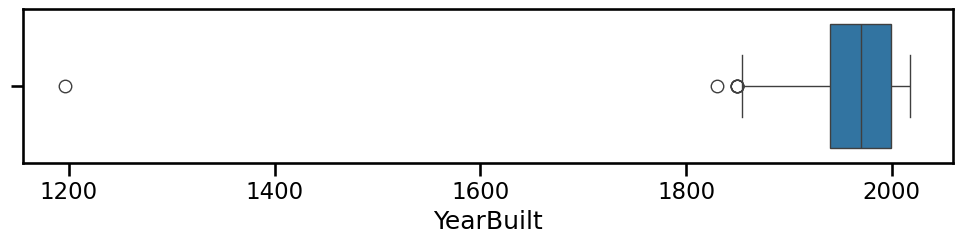

In [63]:
plt.subplots(figsize=(12,2))
sns.boxplot(df_mice.YearBuilt, orient='h')

<Axes: xlabel='BuildingArea'>

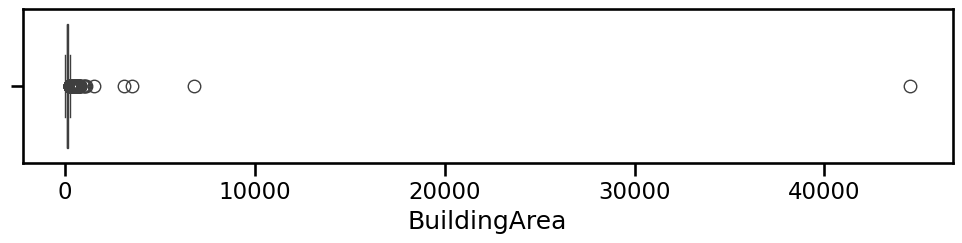

In [64]:
plt.subplots(figsize=(12,2))
sns.boxplot(df_mice.BuildingArea, orient='h')

Se puede establer:

- YearBuilt: los outlier son valores <= 1850
- BuildingArea: los outlier son valores > 300

In [65]:
df_mice = df_mice.loc[(df_mice['YearBuilt'] > 1850) & (df_mice['BuildingArea'] < 300)
| pd.isna(df_mice['YearBuilt']) & pd.isna(df_mice['BuildingArea'])]

También se crea una lista con los nombres de las columnas

In [66]:
columns_list = [n for n in df_mice.columns]

In [67]:
print('Cantidad de columnas:', len(columns_list))

Cantidad de columnas: 371


La cantidad de datos faltantes de 'YearBuilt' y 'BuildingArea' son

In [68]:
columns_add.isna().sum()

YearBuilt       5375
BuildingArea    6450
dtype: int64

### 2.2 Imputación de datos

Se estandarizan los valores de las variables mediante `StandardScaler` ya que es un requisito para muchos estimadores de ML, estos podrian funcionar de forma erronea si las caracaterísticas individuales no se parecen más o menos a datos estandar distribuidos normalmente. Esta técnica transforma las características para que tengan una media de 0 y una desviación estándar de 1.

Se ajustan los valores con el método `.StandardScaler()`. Luego se entrena y transforman los valores mediante `.fit_transform()` para finalmente contruir el DataFrame

Con los valores ecalados se realiza una imputacion iterativa mediante `IterativeImputer` y se especifica el modelo de imputacion **K-Nearest Neighbprs**

Luego, se ajusta el IterativeImputer a los datos y para transformar los datos de modo que los valores faltantes se imputan (se llenan) utilizando el modelo entrenado

Despues se debe volver a los valores originales con `.scaler_inverse()`

#### Ajuste sobre dos variables ('YearBuilt' y 'BuildingArea')

In [69]:
scaler = StandardScaler()

In [70]:
df_mice_scaler = df_mice.copy(deep=True)

In [71]:
scaler.fit(df_mice_scaler)

StandardScaler()

In [72]:
df_mice_scaler = scaler.transform(df_mice_scaler)

In [73]:
df_mice_scaler_KNN = pd.DataFrame(data=df_mice_scaler, columns=columns_list)

In [74]:
df_mice_scaler_KNN.shape

(11645, 371)

In [75]:
df_mice_scaler_KNN[['YearBuilt', 'BuildingArea']].sample(10)

,YearBuilt,BuildingArea
3089,0.855535,0.938590
1542,NaN,NaN
8520,1.020182,1.045109
659,NaN,NaN
3253,-0.928144,2.181305
4601,0.992741,-0.481655
3462,1.157388,-0.357384
1706,0.306711,-1.103012
4158,NaN,NaN
8269,NaN,NaN


Se imputan los valores

In [76]:
mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(n_neighbors=10), max_iter=100)

In [77]:
start = time.time()
df_mice_scaler_KNN[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(df_mice_scaler_KNN[['YearBuilt', 'BuildingArea']])
end = time.time() - start

print('Tiempo: ', end, 'segundos')

Tiempo:  5.664557933807373 segundos


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [78]:
df_mice_scaler_KNN[['YearBuilt', 'BuildingArea']].sample(10)

,YearBuilt,BuildingArea
1732,1.322035,-0.197606
7764,-0.645499,0.269921
1123,0.169505,-1.316049
7918,-1.065350,1.524441
7186,-0.379320,-0.552667
9297,-0.645499,0.269921
8866,-0.645499,0.269921
6427,0.169505,0.246221
10251,-0.645499,0.269921
7455,1.020182,1.915009


In [79]:
df_mice_scaler_KNN = scaler.inverse_transform(df_mice_scaler_KNN)

In [80]:
df_mice_scaler_KNN = pd.DataFrame(data=df_mice_scaler_KNN, columns=columns_list)

In [81]:
df_mice_scaler_KNN[['YearBuilt', 'BuildingArea']].sample(10)

,YearBuilt,BuildingArea
4458,2006.0,128.0
3153,1960.0,91.0
5523,2002.0,83.0
5139,1950.0,112.0
3993,2000.0,84.0
9282,2005.0,132.0
7706,1950.0,175.0
4294,1950.0,272.0
311,1910.0,104.0
784,2011.0,150.0


#### Ajuste sobre dataset reducido

Se ajustan los valores

In [82]:
columnas_nuevas = ['Rooms','Price','Distance','Postcode','Bedroom2','Bathroom',
                   'Car','Landsize','Lattitude','Longtitude','Propertycount',
                   'Type_encoded','Method_encoded','BuildingArea','YearBuilt']

In [83]:
#Method, Date y Type tambien pero hay que codificar

In [84]:
scaler_all = StandardScaler()

In [85]:
df_mice_scaler_all = df_mice[columnas_nuevas].copy(deep=True)

In [86]:
scaler_all.fit(df_mice_scaler_all)

StandardScaler()

In [87]:
df_mice_scaler_all = scaler_all.transform(df_mice_scaler_all)

In [88]:
df_mice_scaler_KNN_all = pd.DataFrame(data=df_mice_scaler_all, columns=columnas_nuevas)

In [89]:
df_mice_scaler_KNN_all.sample(10)

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount,Type_encoded,Method_encoded,BuildingArea,YearBuilt
3397,-1.004855,1.089275,-1.032499,1.134807,-0.961690,-0.770943,-0.613968,-0.096633,-0.551423,-0.269600,-1.232027,-0.592392,2.316030,NaN,NaN
7104,-1.004855,-0.328598,-1.287325,0.189076,-0.961690,-0.770943,-1.653615,-0.104604,-0.032712,0.017450,1.706169,-0.592392,1.338141,NaN,NaN
4882,-2.092459,-1.020452,-1.525162,-1.090444,-2.030490,-0.770943,-1.653615,0.047556,-0.183793,-0.262924,0.217983,0.995273,-0.617636,-1.085259,1.184829
5641,-1.004855,-0.499426,-0.539837,-1.012560,-0.961690,-0.770943,-0.613968,-0.099212,-0.118324,-0.978164,-0.203999,-0.592392,0.360253,NaN,NaN
9647,-1.004855,-0.952121,3.571344,1.034671,-0.961690,-0.770943,-0.613968,-0.084207,-3.416927,1.326052,-1.238844,2.582937,-0.617636,-0.659186,0.443917
6399,-1.004855,1.553927,0.632359,0.678631,-0.961690,-0.770943,0.425680,0.068188,-1.406290,0.606807,0.801759,-0.592392,-0.617636,NaN,NaN
4509,0.082749,0.631456,-1.287325,0.189076,0.107109,-0.770943,-1.653615,-0.051149,-0.167426,0.157637,1.706169,-0.592392,-0.617636,NaN,NaN
9679,-1.004855,-1.111845,1.600695,-0.311606,-0.961690,0.767640,-0.613968,-0.095695,2.229727,0.281612,0.791988,2.582937,-0.617636,NaN,NaN
125,-1.004855,-0.923080,-0.641767,-0.289353,-0.961690,-0.770943,-0.613968,-0.130629,0.348768,0.310221,-1.188397,0.995273,-0.617636,-1.245037,0.032299
1004,-1.004855,1.243020,0.088732,0.923408,1.175909,2.306223,0.425680,0.018250,-1.413844,0.157637,-0.114240,-0.592392,0.360253,-0.215359,-0.790938


In [90]:
df_mice_scaler_KNN_all = df_mice_scaler_KNN_all[columnas_nuevas]

Se imputan los valores

In [91]:
mice_imputer_all = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())

In [92]:
start = time.time()
df_mice_scaler_KNN_all = mice_imputer_all.fit_transform(df_mice_scaler_KNN_all)
end = time.time() - start

print('Tiempo: ', end, 'segundos')
# Ver: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.

Tiempo:  24.618650913238525 segundos


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [93]:
df_mice_scaler_KNN_all = scaler_all.inverse_transform(df_mice_scaler_KNN_all)

In [94]:
df_mice_scaler_KNN_all = pd.DataFrame(data=df_mice_scaler_KNN_all, columns=columnas_nuevas)

In [95]:
df_mice_scaler_KNN_all.sample(10)

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount,Type_encoded,Method_encoded,BuildingArea,YearBuilt
3388,2.0,733000.0,2.8,3000.0,2.0,2.0,1.0,0.0,-37.81660,144.96350,17496.0,1.0,0.0,94.0000,1965.0
8672,3.0,1290000.0,7.7,3124.0,3.0,2.0,2.0,321.0,-37.84627,145.08366,8920.0,0.0,3.0,195.0964,1997.0
4021,2.0,795000.0,3.8,3207.0,2.0,2.0,1.0,579.0,-37.84160,144.93810,8648.0,1.0,0.0,84.0000,2013.0
706,3.0,899000.0,13.9,3165.0,3.0,1.0,1.0,583.0,-37.93120,145.07950,10969.0,0.0,0.0,107.0000,1962.0
134,4.0,780000.0,13.8,3018.0,4.0,1.0,4.0,655.0,-37.86800,144.81540,5301.0,0.0,2.0,135.4000,1970.6
6291,4.0,780000.0,12.5,3041.0,4.0,2.0,2.0,539.0,-37.71150,144.89660,389.0,0.0,3.0,139.4000,1966.0
3177,2.0,510000.0,9.2,3012.0,2.0,1.0,2.0,118.0,-37.78700,144.87480,3873.0,2.0,1.0,91.0000,2014.0
8719,3.0,1360000.0,14.3,3109.0,3.0,2.0,2.0,402.0,-37.79408,145.16352,10999.0,0.0,0.0,200.0000,2007.0
2837,2.0,420000.0,13.0,3166.0,2.0,1.0,1.0,0.0,-37.90080,145.08590,3145.0,1.0,3.0,70.0000,2010.0
9709,2.0,585000.0,16.1,3088.0,2.0,1.0,1.0,240.0,-37.71254,145.09705,8524.0,1.0,0.0,79.0000,1965.0


In [96]:
df_mice_scaler_KNN_all.isna().sum()

Rooms             0
Price             0
Distance          0
Postcode          0
Bedroom2          0
Bathroom          0
Car               0
Landsize          0
Lattitude         0
Longtitude        0
Propertycount     0
Type_encoded      0
Method_encoded    0
BuildingArea      0
YearBuilt         0
dtype: int64

### 2.3 Gráficos

Con las dos tipos de imputacion realizadas se crean los gráficos correspondientes

#### Variable: YearBuilt

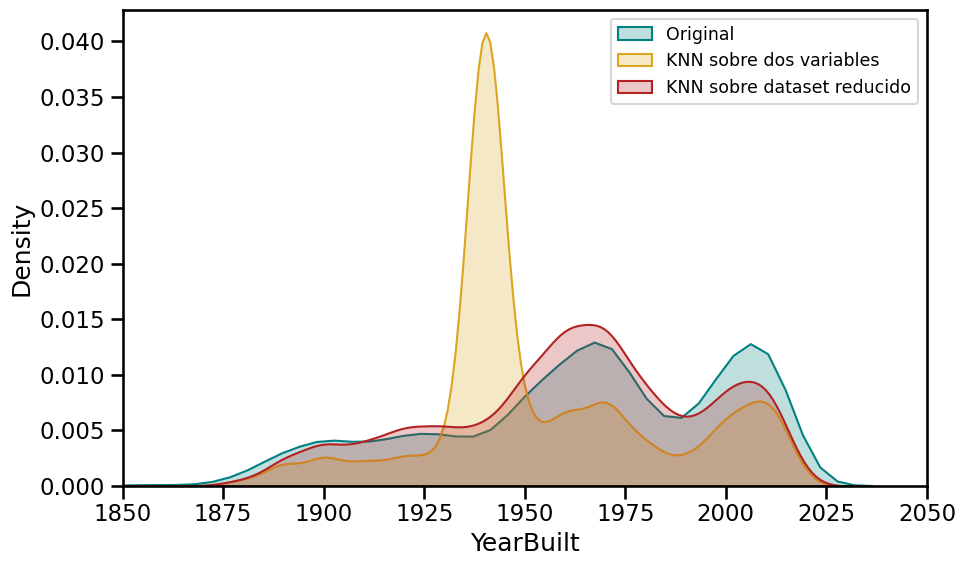

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(data=melb_df, x='YearBuilt', color='teal', fill=True)
sns.kdeplot(data=df_mice_scaler_KNN, x='YearBuilt', color='goldenrod', fill=True)
sns.kdeplot(data=df_mice_scaler_KNN_all, x='YearBuilt', color='firebrick', fill=True)
plt.legend(labels=['Original', 'KNN sobre dos variables', 'KNN sobre dataset reducido'], fontsize='x-small')
plt.xlim(1850, 2050)
plt.tight_layout()

#### Variable: BuildingArea

Se grafica el los datos del DataSet original eliminando los valores nulos. Ver Otros.

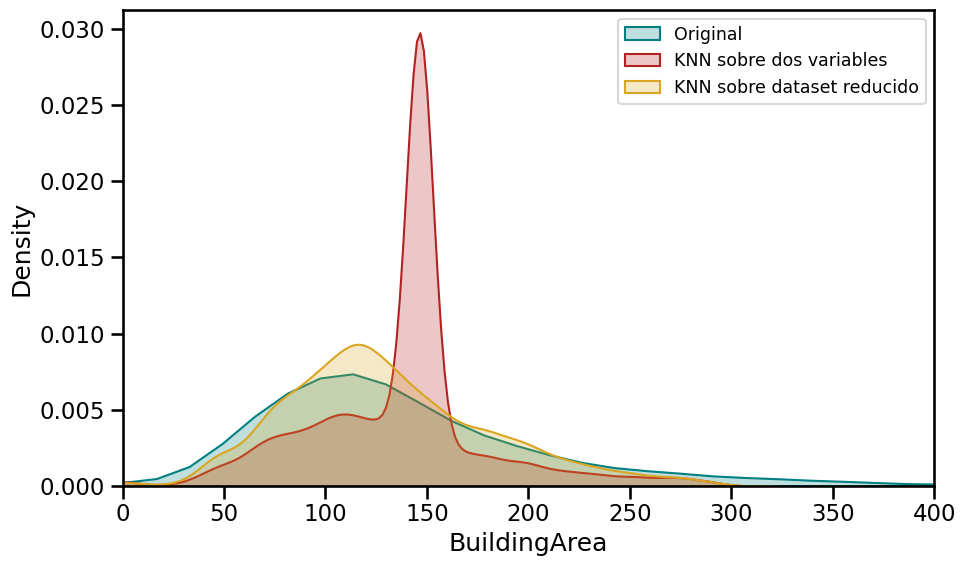

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(data=melb_df.dropna(), x='BuildingArea', color='teal', fill=True)
sns.kdeplot(data=df_mice_scaler_KNN, x='BuildingArea', color='firebrick',fill=True)
sns.kdeplot(data=df_mice_scaler_KNN_all, x='BuildingArea', color='goldenrod', fill=True)
plt.legend(labels=['Original', 'KNN sobre dos variables', 'KNN sobre dataset reducido'], fontsize='x-small')
plt.xlim(0, 400)
plt.tight_layout()

Se puede observar que al imputar solo sobre dos variables, la distribución de los registros con valores nulos no es uniforme, comparado con la distribución con el dataset reducido

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Seleccione las primeras $2$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

### 3.1 Análisis de componentes principales (PCA)

Se crea un nuevo DataFrame a partir del creado en el punto anterior

In [99]:
df_pca = df_mice_scaler_KNN.copy(deep=True)

In [100]:
df_pca.shape

(11645, 371)

In [101]:
df_pca.head()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,Lattitude,Longtitude,...,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,YearBuilt,BuildingArea
0,2.0,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,-37.7996,144.9984,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1940.3,146.335
1,2.0,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,-37.8079,144.9934,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1900.0,79.000
2,3.0,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,-37.8093,144.9944,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1900.0,150.000
3,3.0,850000.0,2.5,3067.0,3.0,2.0,1.0,94.0,-37.7969,144.9969,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1940.3,146.335
4,4.0,1600000.0,2.5,3067.0,3.0,1.0,2.0,120.0,-37.8072,144.9941,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2014.0,142.000


Se escala el DataFrame mediante `MinMaxScaler`

In [102]:
from sklearn.preprocessing import MinMaxScaler

In [103]:
scaler = MinMaxScaler(feature_range=(-1, 1), clip=True)

In [104]:
df_pca_scaled = scaler.fit_transform(df_pca)

Se observa que los valores corresponden entre -1 y 1

In [105]:
np.max(df_pca_scaled), np.min(df_pca_scaled)

(1.0, -1.0)

Se crea otro arreglo pero con los datos estandarizados mediante `StandardScaler`

In [106]:
scaler_std = StandardScaler()

In [107]:
df_pca_std = scaler_std.fit_transform(df_pca)

Se puede observar que la media es cercada a 0 y la desviación estandar cercana a 1

In [108]:
np.mean(df_pca_std),np.std(df_pca_std)

(2.678563202670951e-16, 0.9945945550026756)

Se crean la instancias `PCA`

In [109]:
from sklearn.decomposition import PCA

In [110]:
n = min(20, df_pca_scaled.shape[1])

In [111]:
print(n, df_pca_scaled.shape[1])

20 371


In [112]:
pca = PCA(n_components=n)

In [113]:
pca_std = PCA(n_components=n)

Se entrenan los modelos para cada tipo de estandarización

In [114]:
pca_std.fit(df_pca_std)

PCA(n_components=20)

In [115]:
pca.fit(df_pca_scaled)

PCA(n_components=20)

In [116]:
x_pca = pca.transform(df_pca_scaled)

In [117]:
x_pca_std = pca_std.transform(df_pca_std)

In [118]:
print('Tamaño dataset completo:\t', df_pca_scaled.shape)
print('Tamaño dataset recucido (scal):', x_pca.shape)
print('Tamaño dataset recucido (std.): ', x_pca_std.shape)

Tamaño dataset completo:	 (11645, 371)
Tamaño dataset recucido (scal): (11645, 20)
Tamaño dataset recucido (std.):  (11645, 20)


#### Comparacion de ambos métodos

Se generan dos graficos, uno para mostrar la varianza de cada componente y el otro la varianza acumulada por aca componente

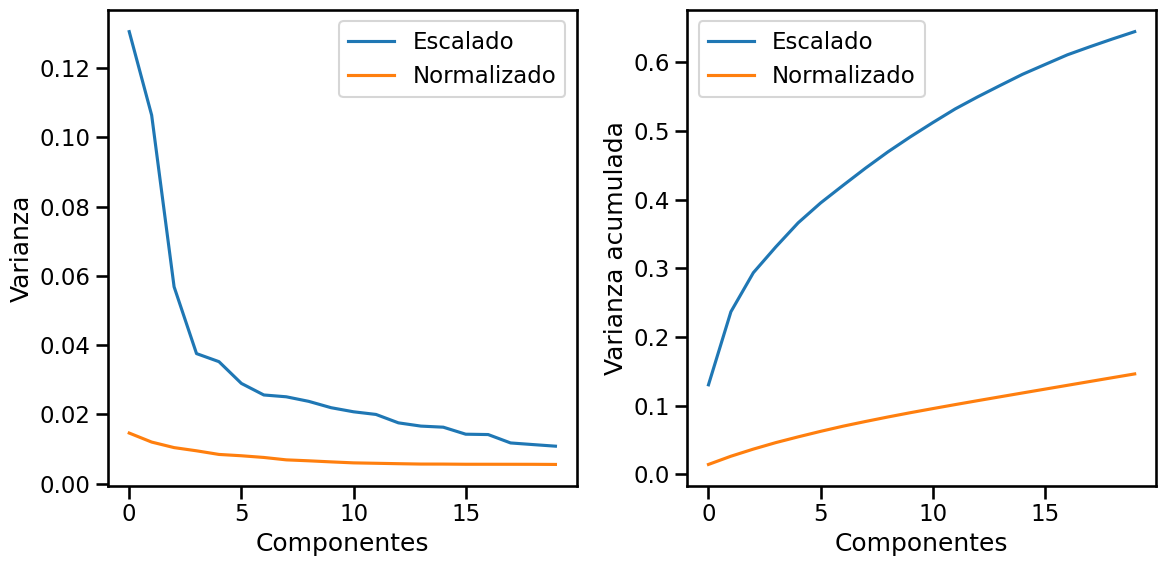

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.lineplot(ax=ax[0], x=range(pca.n_components), y=pca.explained_variance_ratio_, label='Escalado')
sns.lineplot(ax=ax[0], x=range(pca_std.n_components), y=pca_std.explained_variance_ratio_, label='Normalizado')
ax[0].set_ylabel("Varianza")
ax[0].set_xlabel("Componentes")
ax[0].legend()

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
cumulative_explained_variance_std = np.cumsum(pca_std.explained_variance_ratio_)

sns.lineplot(ax=ax[1], x=range(pca.n_components), y=cumulative_explained_variance, label='Escalado')
sns.lineplot(ax=ax[1], x=range(pca_std.n_components), y=cumulative_explained_variance_std, label='Normalizado')

ax[1].set_ylabel("Varianza acumulada")
ax[1].set_xlabel("Componentes")
ax[1].legend()

plt.tight_layout()

Los graficos muestran que escalar los datos antes de obtener los componentes principales representarian más variables con menos componentes. Sin embargo, ni con 20 componentes se llega más de un 60%. Esto se puede deber a:
- Distribucion de los datos
- Ruido de los datos
- Correlacion entre variables, al no tener una correlacion grande la varianza se distribuye entre todos los componentes y no sobre los primeros

### 3.2 Primeros dos componentes y gráfico

Se agregan al dataset los primeros dos componentes principales estandarizados y escalados para comparar los gráficos

In [120]:
df_pca = df_pca.assign(pca1_std=x_pca_std[:, 0], pca2_std=x_pca_std[:, 1], pca1_scal=x_pca[:, 0], pca2_scal=x_pca[:, 1])

#### Gráfico

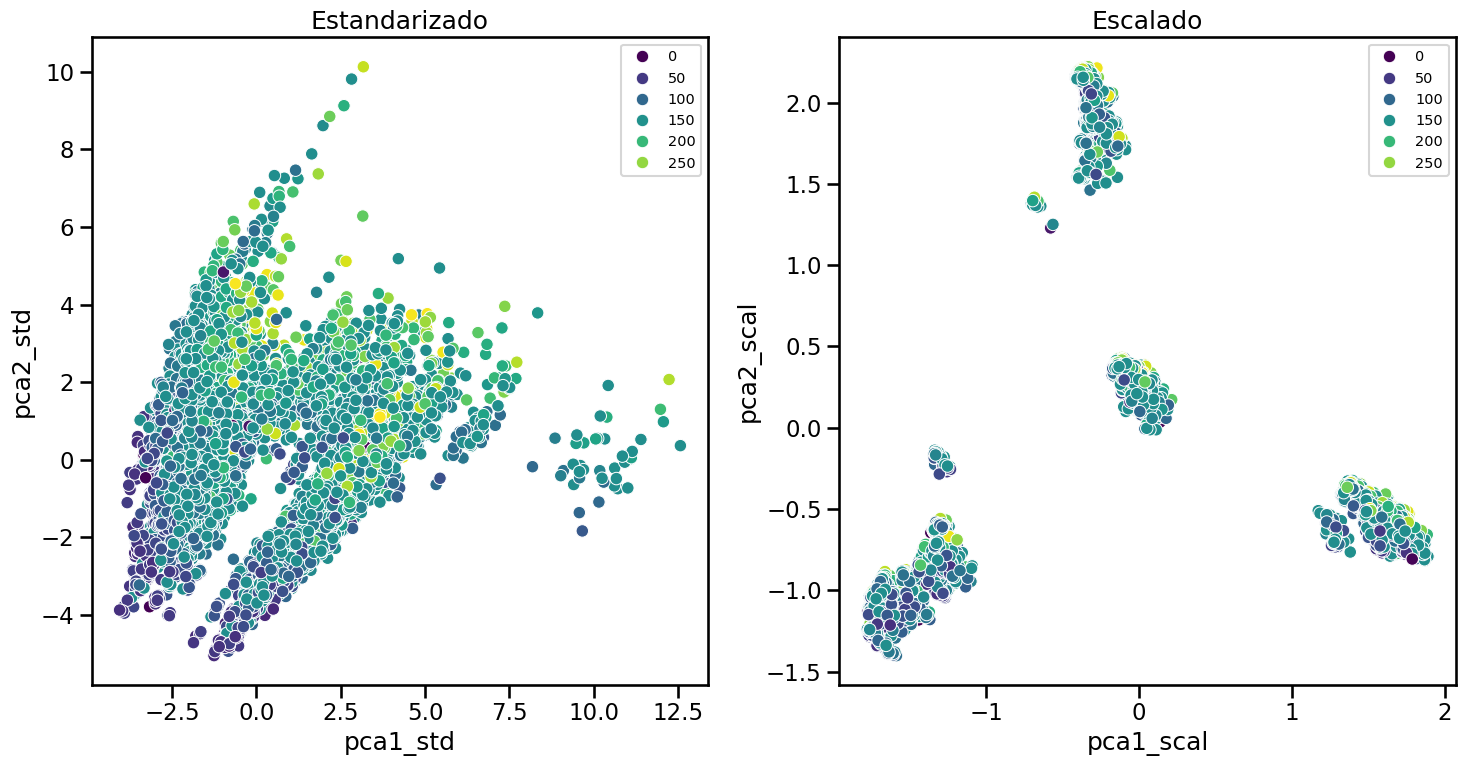

In [121]:
variable = 'BuildingArea'
muestra = 10000

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

sns.scatterplot(ax=ax[0], data=df_pca.sample(muestra), x='pca1_std', y='pca2_std', hue=variable, palette='viridis')
ax[0].set_title('Estandarizado')
ax[0].legend(fontsize='xx-small')

sns.scatterplot(ax=ax[1], data=df_pca.sample(muestra), x='pca1_scal', y='pca2_scal', hue=variable, palette='viridis')
ax[1].set_title('Escalado')
ax[1].legend(fontsize='xx-small')

plt.tight_layout()

Se puedre crear un gráfico en 3D con una tercer componente principal

In [ ]:
import plotly.express as px
import plotly.colors as colors

In [133]:
pca_3 = PCA(n_components=3)
components = pca_3.fit_transform(df_pca_std)

total_var = pca_3.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=df_pca['Type_encoded'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
    color_continuous_scale=colors.sequential.Viridis
)
fig.show()

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de
     publicaciones de la plataforma AirBnB en el mismo código
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```


<a id="otros"></a>
# Otros

- El kdeplot (Kernel Density Estimate plot) de Seaborn estima la densidad de probabilidad de los datos utilizando una función de kernel. Este proceso de estimación puede extender el rango de los datos, especialmente si hay valores atípicos o si el ancho de banda (bandwidth) del kernel es grande.
- El KDE puede mostrar valores negativos en el eje X como resultado del suavizado, especialmente si el ancho de banda no está ajustado correctamente.
- El kernel se superpone en los puntos de datos y, si el kernel se extiende más allá del rango mínimo de los datos, puede producir estimaciones en el rango negativo, aunque no haya datos negativos en tu conjunto.

(-300.0, 300.0)

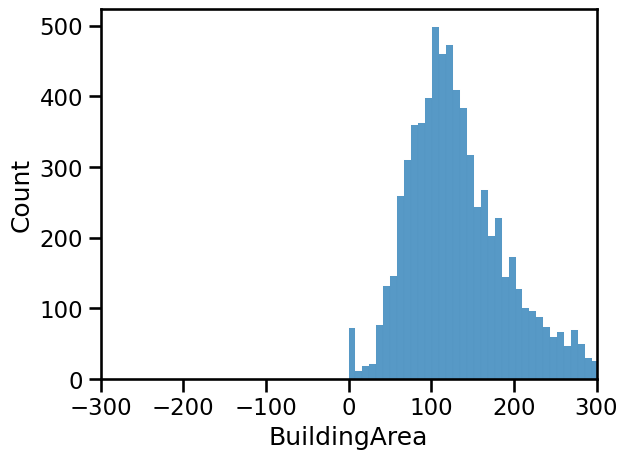

In [123]:
sns.histplot(data=melb_df, x='BuildingArea')
plt.xlim(-300,300)

(-300.0, 700.0)

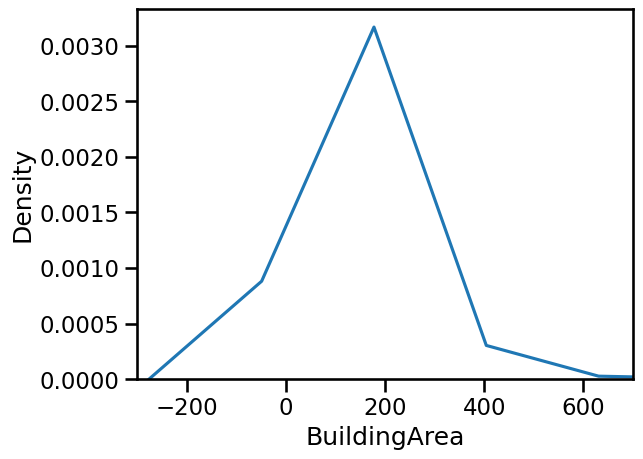

In [124]:
sns.kdeplot(data=melb_df, x='BuildingArea')
plt.xlim(-300,700)

(-300.0, 700.0)

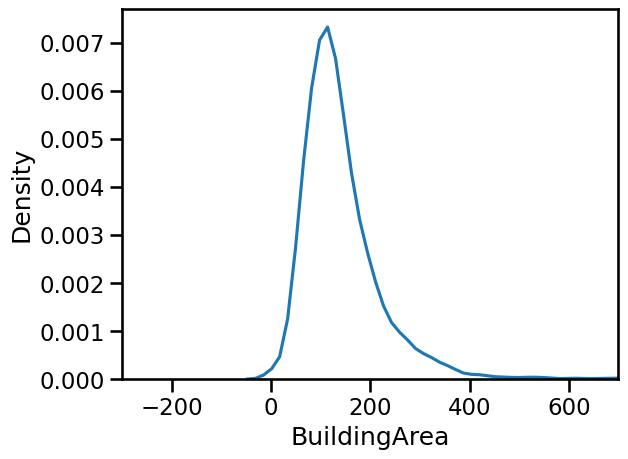

In [125]:
sns.kdeplot(data=melb_df.dropna(), x='BuildingArea')
plt.xlim(-300,700)